# HL-HGAT Tutorial

### Install and load required packages

In [1]:
from torch.nn import Linear, Dropout
import torch
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_max_pool
import torch_geometric.nn as gnn
import torch_geometric.utils as gutils
import torch.nn as nn
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import add_self_loops, degree, to_undirected
from torch_geometric.data import Data
from lib.Hodge_Cheb_Conv import *
from lib.Hodge_Dataset import *
from lib.Hodge_ST_Model import *
from scipy.io import savemat
import scipy.io as io
import numpy as np

import mat73
import os
import matplotlib.pyplot as plt

## Introduction: Graphs in PyTorch Geometric


Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.
We can print the data object anytime via `print(graph)` to receive a short summary about its attributes and their shapes:


In [2]:
dataset = GNNBenchmarkDataset(root='data/CIFAR10_bm',name='CIFAR10',split='test')
graph = dataset[0]
graph

Data(x=[118, 3], edge_index=[2, 944], edge_attr=[944], y=[1], pos=[118, 2])

We can see that this `graph` object holds 4 attributes:
(1) The `edge_index` property holds the information about the **graph connectivity**, *i.e.*, a tuple of source and destination node indices for each edge.
PyG further refers to (2) **node features** as `x` ( with dimension number of nodes $\times$ number of node features per node), and to (3) **labels** as `y` (each graph is assigned to one class).
(4) **edge features** as `edge_attr` ( with dimension number of edges $\times$ number of edge features per edge).
Let us now inspect the `edge_index` property in more detail:

In [3]:
graph.edge_index.T

tensor([[  0,  54],
        [  0, 105],
        [  0,  46],
        ...,
        [117,  44],
        [117,  43],
        [117,   8]])

By printing `edge_index`, we can understand how PyG represents graph connectivity internally.
We can see that for each edge, `edge_index` holds a tuple of two node indices, where the first value describes the node index of the source node and the second value describes the node index of the destination node of an edge.

This representation is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.
Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero.

Importantly, PyG does not distinguish between directed and undirected graphs, and treats undirected graphs as a special case of directed graphs in which reverse edges exist for every entry in `edge_index`.


### Transform a graph to a heterogeneous graph

We define nodes and edges in a graph as different kind of nodes in a corresponding heterogeneous graph. We use `PairData` instead of `Data` representing this kind of data.

In `PairData`, we represent node and edge features as `x_t` and `x_s`. The Hodge-Laplacian operator is defined in a sparse matrix manner (similar to `edge_index`), with `edge_index_t, edge_weight_t` and `edge_index_s, edge_weight_s` representing the 0-th and 1-st HL operator, correspondingly. 

In [4]:
def graph2hgraph(data):
    '''
    transform a graph to a heterogeneous graph
    '''
    edge_index,edge_attr = to_undirected(graph.edge_index, graph.edge_attr, reduce='min')
    idx = edge_index[0]<edge_index[1]
    edge_index,edge_attr = edge_index[:,idx], edge_attr[idx]

    par1 = adj2par1(edge_index, graph.x.shape[0], edge_index.shape[1]).to_dense()
    L0 = torch.matmul(par1, par1.T)
    lambda0, _ = torch.linalg.eigh(L0)
    maxeig = lambda0.max()
    L0 = 2*torch.matmul(par1, par1.T)/maxeig
    L1 = 2*torch.matmul(par1.T, par1)/maxeig
    x_s = edge_attr.view(-1,1)
    x_t = graph.x
    data = PairData(x_s=x_s, edge_index_s=None, edge_weight_s=None,
                      x_t=x_t, edge_index_t=None, edge_weight_t=None,
                      y = data.y)
    edge_index_t, edge_weight_t = dense_to_sparse(L0)
    edge_index_s, edge_weight_s = dense_to_sparse(L1)
    data.edge_index_t, data.edge_weight_t = edge_index_t, edge_weight_t
    data.edge_index_s, data.edge_weight_s = edge_index_s, edge_weight_s
    data.num_node1 = data.x_t.shape[0]
    data.num_edge1 = data.x_s.shape[0]
    data.num_nodes = data.x_t.shape[0]
    data.edge_index=edge_index
    return data

In [5]:
graph = dataset[0]
hgraph = graph2hgraph(graph)
hgraph

PairData(x_s=[565, 1], x_t=[118, 3], y=[1], edge_index_t=[2, 1248], edge_weight_t=[1248], edge_index_s=[2, 10371], edge_weight_s=[10371], num_node1=118, num_edge1=565, num_nodes=118, edge_index=[2, 565])

The boundary operator is stored as `edge_index`, which can be transformed to a dense matrix with a `adj2par1` function.

In [6]:
par1 = adj2par1(hgraph.edge_index, hgraph.num_node1, hgraph.num_edge1)
par1.to_dense()

tensor([[-1., -1., -1.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  1.,  1.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

### Build heterogeneous graph with brain fMRI

We store all brain fMRI data in a `.mat` file, which contains a cell matrix (dimension: number of samples $\times4$). Each row corresponds to a sample, with the first column containing fMRI time-series data (dimension: number of ROIs $\times$ number of time points). The second column is optional, which stores the structural connectivity (dimension: number of ROIs $\times$ number of ROIs). If you do not have these SC data, you can simply leave blank in the second column. The third column contains different scores of each sample for prediction or further analysis. The final column contains the subject ID of each sample.

In [7]:
### Load '.mat' dataset
name = 'data/DEMO_DATA.mat'
matdata = loadmat(name)
matdata = matdata['DEMO_DATA']
num_samples = len(matdata)
num_rois = matdata[0][0].shape[0]
print('Number of samples: {} -- Number of ROIs: {}'.format(num_samples, num_rois))

Number of samples: 50 -- Number of ROIs: 268


In [8]:
### Compute group-level FC mask
k_ratio = 0.25   ## percentage of non-zero values in the mask 
FC = torch.zeros(num_samples,num_rois,num_rois)
for i in range(num_samples):
    FC[i] = torch.corrcoef(torch.tensor(matdata[i][0]))
mask = FC2mask(FC, k_ratio=k_ratio)
masked_FC = mask * FC.mean(dim=0)
skeleton = masked_FC.to_sparse()
print('Number of functional connectivity after thresholding: {}'.format(len(skeleton.values())))

Number of functional connectivity after thresholding: 8843


In [9]:
par1 = adj2par1(skeleton.indices(), num_rois, skeleton.indices().shape[-1]).to_dense()
L0 = torch.matmul(par1, par1.T)
lambda0, _ = torch.linalg.eigh(L0)
maxeig = lambda0.max()
L0 = 2*torch.matmul(par1, par1.T)/maxeig
L1 = 2*torch.matmul(par1.T, par1)/maxeig
eit, ewt = dense_to_sparse(L0)
eis, ews = dense_to_sparse(L1)
graph = PairData(x_s=skeleton.values().view(-1,1),edge_index_s=eis,edge_weight_s=ews,
                x_t=torch.ones(num_rois,1),edge_index_t=eit,edge_weight_t=ewt,
                edge_index=skeleton.indices())
graph.num_node1 = num_rois
graph.num_edge1 = skeleton.indices().shape[1]
graph.num_nodes = num_rois
graph

PairData(edge_index_s=[2, 1401533], x_s=[8843, 1], edge_index_t=[2, 17953], x_t=[268, 1], edge_weight_s=[1401533], edge_weight_t=[17953], edge_index=[2, 8843], num_node1=268, num_edge1=8843, num_nodes=268)

## Simplex downsampling (graph coarsening)

We save the node and edge cluster information in `pos_t` and `pos_s`. Nodes (or edges) in the same cluster will have the same index. Nodes (or edges) labeled as `inf` will be discarded after pooling. The coarsened heterogeneous graph will be appended to a list. So each sample is represented with a list, containing graphs in different spatial dimension.

In [10]:
# precompute pooling
graphs = [graph]
pool_num = 2
for i in range(pool_num):
    graph, c_node, c_edge = MLGC_Weight(graphs[i])
    graphs[i].pos_s, graphs[i].pos_t = c_edge, c_node
    graphs.append(graph)

num_nodepedge = []
for graph in graphs:
    par = adj2par1(graph.edge_index, graph.num_node1, graph.edge_index.shape[-1]).to_dense()
    num_nodepedge.append(par.shape[1] + par.shape[0]) # number of nodes and edges after pooling
graphs

[PairData(edge_index_s=[2, 1401533], x_s=[8843, 1], edge_index_t=[2, 17953], x_t=[268, 1], edge_weight_s=[1401533], edge_weight_t=[17953], edge_index=[2, 8843], num_node1=268, num_edge1=8843, num_nodes=268, pos_s=[8843, 1], pos_t=[268, 1]),
 PairData(edge_index_s=[2, 230153], x_s=[2561, 1], edge_index_t=[2, 5265], x_t=[143, 1], edge_weight_s=[230153], edge_weight_t=[5265], edge_index=[2, 2561], num_node1=143, num_edge1=2561, num_nodes=143, pos_s=[2561, 1], pos_t=[143, 1]),
 PairData(edge_index_s=[2, 37240], x_s=[742, 1], edge_index_t=[2, 1562], x_t=[78, 1], edge_weight_s=[37240], edge_weight_t=[1562], edge_index=[2, 742], num_node1=78, num_edge1=742, num_nodes=78)]

## Dataset and graph batching

Neural networks are usually trained in a batch-wise fashion. In some cases, the number of nodes or edges are different between samples. In this scenario, PyTorch Geometric solve the mini-batch problem by building a large graph. Consider n samples with adjacency matrix \{A_1,\dots,A_n\} and node signals \{X_1,\dots,X_n\}, the adjacency matrix and node signals of the batched graph is written as:
$$A = \begin{bmatrix}
A_1&0&0\\
0&\dots&0\\
0&0&A_n\\
\end{bmatrix},
\quad
X = \begin{bmatrix}
X_1\\
\dots\\
X_n\\
\end{bmatrix}.
$$

In [11]:
batch_size = 5
dataset = Brain_MLGC_ALL('Brain', matdata, skeleton, graphs, pool_num=pool_num)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
graph_batch = next(iter(train_loader))
print(graph_batch)
print(graph_batch[-1].ptr)

[PairDataBatch(edge_index_s=[2, 7007665], x_s=[44215, 1], edge_index_t=[2, 89765], x_t=[1340, 375], edge_weight_s=[7007665], edge_weight_t=[89765], edge_index=[2, 44215], num_node1=[5], num_edge1=[5], num_nodes=1340, pos_s=[44215, 1], pos_t=[1340, 1], y=[5], batch=[1340], ptr=[6]), PairDataBatch(edge_index_s=[2, 1150765], x_s=[12805, 1], edge_index_t=[2, 26325], x_t=[715, 1], edge_weight_s=[1150765], edge_weight_t=[26325], edge_index=[2, 12805], num_node1=[5], num_edge1=[5], num_nodes=715, pos_s=[12805, 1], pos_t=[715, 1], batch=[715], ptr=[6]), PairDataBatch(edge_index_s=[2, 186200], x_s=[3710, 1], edge_index_t=[2, 7810], x_t=[390, 1], edge_weight_s=[186200], edge_weight_t=[7810], edge_index=[2, 3710], num_node1=[5], num_edge1=[5], num_nodes=390, batch=[390], ptr=[6])]
tensor([  0,  78, 156, 234, 312, 390])


## Implement HL-HGAT

### Temporal convolution of fMRI time-series
Hyperparameters of the inception module:
- in_channels: number of channels in the initial 1D-conv
- num_channels: number of channels in the inception module
- maxpool: size of the sliding window
- if_readout: if reduce the time dimension with averaging 

Inputs of the inception module:
- node signal (dimension: number of nodes $\times$ number of time points)

Outputs of the inception module:
- node signal (dimension: number of nodes $\times$ 4*num_channels)

In [12]:
init_time_conv = 16
node_dim = 32
time_pool_step = 5
timeconv = Inception1D(in_channels=init_time_conv, num_channels=int(node_dim/8), 
                       maxpool=time_pool_step, if_readout=True)
print('size of the input node signal: {}'.format(graph_batch[0].x_t.shape))
x_t = timeconv(graph_batch[0].x_t)
print('size of the output node signal: {}'.format(x_t.shape))

size of the input node signal: torch.Size([1340, 375])
size of the output node signal: torch.Size([1340, 32])


### HL-filters
Convolutional layer on node and edge signals 

Hyperparameters of the inception module:
- channels: number of HL-filtering layer
- filters: number of filters in each layer
- K: polynomial order
- node_dim: input node dimension
- edge_dim: input edge dimension

Inputs of the inception module:
- x_t, edge_index_t, edge_weight_t, x_s, edge_index_s, edge_weight_s

Outputs of the inception module:
- node and edge signal (dimension: number of nodes/edges $\times$ filters)


In [13]:
edge_dim = 1
dropout_ratio = 0.25
leaky_slope = 0.1
conv =  HL_filter(channels=1, filters=32, K=4, node_dim=node_dim,
                  edge_dim=edge_dim, dropout_ratio=dropout_ratio, 
                  leaky_slope=leaky_slope,if_dense=False)
print('size of the input node and edge signal: {}, {}'.format(x_t.shape, graph_batch[0].x_s.shape))
x_t, x_s = conv(x_t, graph_batch[0].edge_index_t, graph_batch[0].edge_weight_t,
                graph_batch[0].x_s, graph_batch[0].edge_index_s, graph_batch[0].edge_weight_s)
print('size of the output node and edge signal: {}, {}'.format(x_t.shape, x_s.shape))

size of the input node and edge signal: torch.Size([1340, 32]), torch.Size([44215, 1])
size of the output node and edge signal: torch.Size([1340, 32]), torch.Size([44215, 32])


### Multi-simplicial Interaction (MSI)
MSI layer on node and edge signals

Hyperparameters of MSI:
- d: input feature dim
- dk: feature dim of key & query
- dv: feature dim of value
- dl: feature dim of latent
- only_att: if true, only output the attention value
- sigma: activation function

Inputs of MSI:
- x_t, x_s: node and edge signals
- par_1: boundary operator (sparse matrix, dim: [number of nodes, number of edges])
- D: degree matrix (dim: number of nodes)

Outputs of MSI:
- node and edge signal (dimension: number of nodes/edges $\times$ filters)


In [14]:
msi = MSI(d=32, dv=32)
par_1 = adj2par1(graph_batch[0].edge_index, x_t.shape[0], x_s.shape[0])
D = degree(graph_batch[0].edge_index.view(-1),num_nodes=x_t.shape[0]) + 1e-6   
print('size of the input node and edge signal: {}, {}'.format(x_t.shape, x_s.shape))
x_t, x_s = msi(x_t, x_s, par_1, D)
print('size of the output node and edge signal: {}, {}'.format(x_t.shape, x_s.shape))

size of the input node and edge signal: torch.Size([1340, 32]), torch.Size([44215, 32])
size of the output node and edge signal: torch.Size([1340, 32]), torch.Size([44215, 32])


### Simplicial Attention Pooling (SAP)
Hyperparameters of SAP:
- d: input feature dim
- dk: feature dim of key & query

Inputs of MSI:
- x_t, x_s: node and edge signals
- par_1: boundary operator (sparse matrix, dim: [number of nodes, number of edges])
- D: degree matrix (dim: number of nodes)
- graph_batch: a list of graphs
- pos_ts, pos_ss: two lists of the node and edge cluster indices
- k: spatial level, increase 1 after pooling

Outputs of MSI:
- x_t, x_s: node and edge signals
- par_1: boundary operator (sparse matrix, dim: [number of nodes, number of edges])
- D: degree matrix (dim: number of nodes)
- k: spatial level
- edge_index_t ... : updated Hodge-Laplacian operator
- att_t, att_s: node and edge attention

In [15]:
fc = SAPool(d=32, dk=16)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
pos_ts, pos_ss = [], []
for p in range(pool_num):
    n_batch = torch.cat( [torch.tensor([i]*nn) for i,nn in enumerate(graph_batch[p].num_node1)], dim=-1)
    s_batch = torch.cat( [torch.tensor([i]*nn) for i,nn in enumerate(graph_batch[p].num_edge1)], dim=-1)
    n_ahead = torch.cumsum(torch.cat([torch.zeros(1),graph_batch[p+1].num_node1],dim=-1), dim=0, 
                           dtype=torch.long)[:-1]
    s_ahead = torch.cumsum(torch.cat([torch.zeros(1),graph_batch[p+1].num_edge1],dim=-1), dim=0, 
                           dtype=torch.long)[:-1]
    pos_ts.append((graph_batch[p].pos_t.view(-1) + n_ahead[n_batch]).view(-1,1))
    pos_ss.append((graph_batch[p].pos_s.view(-1) + s_ahead[s_batch]).view(-1,1))

k = 0  ## spatial level, increase 1 after pooling
print('size of the input node and edge signal: {}, {}'.format(x_t.shape, x_s.shape))
x_t, x_s, par_1, D, k, edge_index_t, edge_weight_t, edge_index_s, edge_weight_s, att_t, att_s = fc(x_t, x_s, par_1, D, 
                                                                                                   graph_batch, pos_ts, 
                                                                                                   pos_ss, k, device=device)
print('size of the output node and edge signal: {}, {}'.format(x_t.shape, x_s.shape))

size of the input node and edge signal: torch.Size([1340, 32]), torch.Size([44215, 32])
size of the output node and edge signal: torch.Size([715, 32]), torch.Size([12805, 32])


### HL-HGAT

In [16]:
class HL_HGAT(torch.nn.Module):
    def __init__(self, num_layers=[2,2,2], channels=[32,64,128], mlp_channels=[], 
                 K=4, node_dim=64, init_time_conv=64, time_pool_step=5, edge_dim=1, 
                 num_classes=1, dropout_ratio=0.0, pool_num=2, leaky_slope = 0.1,
                 keig=0, dk=64, num_nodepedge=None):
        self.num_layers = num_layers
        self.channels = channels
        self.mlp_channels = mlp_channels
        self.node_dim = node_dim + keig
        self.edge_dim = edge_dim + keig
        self.initial_channel = self.channels[0]
        self.pool_loc = [i for i in range(pool_num)]
        self.keig = keig # number of eigenvalue
        self.num_nodepedge = num_nodepedge
        super().__init__()
        
        ## Temporal convolution of fMRI time-series
        self.node_embedding = Inception1D(in_channels=init_time_conv, num_channels=int(node_dim/8), 
                                          maxpool=time_pool_step, if_readout=True)
        ## Initial HL-filter
        self.HL_init_conv = HL_filter(channels=1, filters=self.initial_channel, K=K, node_dim=self.node_dim,
                                      edge_dim=self.edge_dim, dropout_ratio=dropout_ratio, 
                                      leaky_slope=leaky_slope,if_dense=False)
        gcn_insize = self.initial_channel
        
        ## multiple blocks
        for i, gcn_outsize in enumerate(self.channels):
            if self.num_layers[i] == 0:
                continue
            fc = HL_filter(channels=self.num_layers[i], filters=gcn_outsize, K=K, node_dim=gcn_insize, 
                           edge_dim=gcn_insize, dropout_ratio=dropout_ratio, leaky_slope=leaky_slope)
            setattr(self, 'HLconv{}'.format(i), fc)
            gcn_insize = gcn_insize + self.num_layers[i]*gcn_outsize
            
            fc = MSI(d=gcn_insize, dv = gcn_outsize)
            setattr(self, 'MSI{}'.format(i), fc)
            gcn_insize = gcn_insize + gcn_outsize
            
            if i in self.pool_loc:
                fc = SAPool(d=gcn_insize, dk=dk)
                setattr(self, 'SAP{}'.format(i), fc)
        
        ## Readout
        layers = [(HodgeLaguerreConv(gcn_insize, 1, K=1),
                    'x_t, edge_index_t, edge_weight_t -> x_t'),
                  (HodgeLaguerreConv(gcn_insize, 1, K=1),
                    'x_s, edge_index_s, edge_weight_s -> x_s'),
                  (lambda x1, x2: [x1,x2],'x_t, x_s -> x'),]
        self.readout = gnn.Sequential('x_t, edge_index_t, edge_weight_t, x_s, edge_index_s, edge_weight_s', layers)  
        
        ## output layer
        mlp_insize = self.num_nodepedge 
        for i, mlp_outsize in enumerate(mlp_channels):
            fc = nn.Sequential(
                Linear(mlp_insize, mlp_outsize),
                nn.BatchNorm1d(mlp_outsize),
                nn.LeakyReLU(negative_slope=leaky_slope),
                nn.Dropout(dropout_ratio),
                )
            setattr(self, 'mlp%d' % i, fc)
            mlp_insize = mlp_outsize

        self.out = Linear(mlp_insize, num_classes)


    def forward(self, datas, device='cuda:0'):
        data = datas[0].to(device)
        # 1. node & edge postion
        pos_ts, pos_ss = [], []
        for p in range(len(self.pool_loc)):
            n_batch = torch.cat( [torch.tensor([i]*nn) for i,nn in enumerate(datas[p].num_node1)], dim=-1)
            n_batch = n_batch.to(device)
            s_batch = torch.cat( [torch.tensor([i]*nn) for i,nn in enumerate(datas[p].num_edge1)], dim=-1)
            s_batch = s_batch.to(device)
            n_ahead = torch.cumsum(torch.cat([torch.zeros(1),datas[p+1].num_node1],dim=-1).to(device), dim=0, dtype=torch.long)[:-1]
            s_ahead = torch.cumsum(torch.cat([torch.zeros(1),datas[p+1].num_edge1],dim=-1).to(device), dim=0, dtype=torch.long)[:-1]
            pos_ts.append((datas[p].pos_t.to(device).view(-1) + n_ahead[n_batch]).view(-1,1))
            pos_ss.append((datas[p].pos_s.to(device).view(-1) + s_ahead[s_batch]).view(-1,1))
            
        x_s, edge_index_s, edge_weight_s = data.x_s, data.edge_index_s, data.edge_weight_s
        x_t, edge_index_t, edge_weight_t = data.x_t, data.edge_index_t, data.edge_weight_t
        
        # 2. Obtain node & edge embeddings
        x_t = self.node_embedding(x_t)
        
        x_t0, x_s0 = self.HL_init_conv(x_t, edge_index_t, edge_weight_t, x_s, edge_index_s, edge_weight_s)
        k = 0
        par_1 = adj2par1(datas[k].edge_index.to(device), x_t0.shape[0], x_s0.shape[0])
        D = degree(datas[k].edge_index.view(-1).to(device),num_nodes=x_t0.shape[0]) + 1e-6
        for i, channel in enumerate(self.num_layers):
            if channel == 0:
                continue
            fc = getattr(self, 'HLconv{}'.format(i))
            x_t0, x_s0 = fc(x_t0, edge_index_t, edge_weight_t, x_s0, edge_index_s, edge_weight_s,par_1,D)
            fc = getattr(self, 'MSI{}'.format(i))
            x_t, x_s = fc(x_t0, x_s0, par_1, D)
            x_t0 = torch.cat([x_t0, x_t], dim=-1)
            x_s0 = torch.cat([x_s0, x_s], dim=-1)
                
            # structural pooling        
            if i in self.pool_loc:
                fc = getattr(self, 'SAP{}'.format(i))
                x_t0, x_s0, par_1, D, k, edge_index_t, edge_weight_t, edge_index_s, edge_weight_s, att_t, att_s = fc(x_t0, x_s0, par_1, D, 
                                                                                                                     datas, pos_ts, pos_ss, 
                                                                                                                     k, device=device)
                if k == 1:
                    node_att, edge_att = att_t.view(data.num_graphs,-1), att_s.view(data.num_graphs,-1)
        
        # 2. Readout layer
        x_t, x_s = self.readout(x_t0, edge_index_t, edge_weight_t, x_s0, edge_index_s, edge_weight_s)
        x = torch.cat([x_s.view(data.num_graphs,-1), x_t.view(data.num_graphs,-1)], dim=-1)
        
        # 3. Apply a final classifier
        for i, _ in enumerate(self.mlp_channels):
            fc = getattr(self, 'mlp%d' % i)
            x = fc(x)

        return self.out(x), x, node_att, edge_att

### Build HL-HGAT with three blocks
HL-HGAT is highly modularized for easy use. User can build a HL-HGAT with multiple blocks, with each block containing a number of HL-filtering layers and an MSI layer. The number of blocks is determined by the length of two lists (`num_layers` and `channels`), which determines the number of HL-filtering layers and the number of channels of each HL-filtering layer, respectively.

Hyperparameters of the HL-HGAT:
- num_layers: number of HL-filtering layers in each block (list, if contain two blocks then the length equals 2)
- num_channels: number of channels in each HL-filtering layer (list, same length as `num_layers`)
- mlp_channels: number of hidden neurons in each fully connected layer (list, empty if no hidden layer)
- init_time_conv: number of channels in the initial temporal convolutional layer
- node_dim: number of channels in the inception module
- time_pool_step: size of the sliding window

Inputs of the inception module:
- graph_batch: a list of graphs

Outputs of the inception module:
- pred: prediction result
- latent: latent representation of the final layer
- node_att, edge_att: node and edge attention from the first layer

In [17]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
pool_num = 2
#### An example of a HL-HGAT with three blocks and one fully connected layer
model = HL_HGAT(num_layers=[2,2,2], channels=[32,64,128], mlp_channels=[], 
                K=4, node_dim=64, init_time_conv=64, time_pool_step=5, edge_dim=1, 
                num_classes=1, dropout_ratio=0.0, pool_num=pool_num, leaky_slope = 0.1,
                keig=0, dk=64, num_nodepedge=num_nodepedge[pool_num]).to(device)
pred, latent, node_att, edge_att = model(graph_batch, device=device)
pred

tensor([[ 0.0531],
        [-0.1550],
        [ 0.4087],
        [-0.0917],
        [ 0.1118]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Training and Testing

In [18]:
#### define training and testing sets
batch_size = 5
trainset = Subset(dataset, range(40))
testset = Subset(dataset, range(40,50))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size)

#### define loss function
lr, l2 = 1e-4, 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
criterion = torch.nn.MSELoss()
criterion1 = torch.nn.L1Loss()

In [19]:
def train(loader):
    model.train()
    total_loss = 0
    y_pred, y = [], []
    for data in loader:  # Iterate in batches over the training dataset.
        out,_,_,_ = model(data, device=device)  
        loss = criterion( out, data[0].y.view(-1,1))  # Compute the loss.
        total_loss += loss*data[0].num_graphs
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        y_pred.extend(out.squeeze())
        y.extend(data[0].y.squeeze())
       
    y_pred, y = torch.tensor(y_pred), torch.tensor(y)
    y_pred = (y_pred - y_pred.mean()) / y_pred.std()
    y = (y - y.mean()) / y.std() 
    return torch.sqrt(total_loss/len(loader.dataset)), torch.mean(y_pred*y)


In [20]:
def test(loader):
    model.eval()
    y_pred, y = [], []
    total_loss, rmse = 0, 0

    for idx, data in enumerate(loader):  # Iterate in batches over the test dataset. 
        with torch.no_grad():
            out,_,_,_ = model(data, device=device)  
        loss = criterion1(out, data[0].y.view(-1,1))   # Compute the loss.
        rmse += criterion(out, data[0].y.view(-1,1))*data[0].num_graphs
        total_loss += loss * data[0].num_graphs
        y_pred.extend(out.squeeze())
        y.extend(data[0].y.squeeze())

    y_pred, y = torch.tensor(y_pred), torch.tensor(y)
    y_pred = (y_pred - y_pred.mean()) / y_pred.std()
    y = (y - y.mean()) / y.std() 
    return torch.mean(y_pred*y), total_loss/len(loader.dataset), torch.sqrt(rmse/len(loader.dataset))


In [21]:
num_epoch = 4  ### maximum number of epochs
start = time.time()
for epoch in range(0, num_epoch):
    total_loss, train_corr = train(train_loader)
    elapsed = (time.time()-start) / 60
    print(f'Epoch: {epoch:03d}, time: {elapsed:.2f} Train Loss: {total_loss:.4f}, Train Corr: {train_corr:.4f}') 
    best_corr1, best_loss1, best_rmse1 = test(test_loader)
    print('==================================================================================')
    print(f'Test Loss: {best_loss1:.4f}, Test Corr: {best_corr1:.4f}, Test RMSE: {best_rmse1:.4f}')
    print('==================================================================================\n')

Epoch: 000, time: 0.07 Train Loss: 60.2791, Train Corr: 0.1313
Test Loss: 48.1949, Test Corr: -0.0164, Test RMSE: 52.9917

Epoch: 001, time: 0.14 Train Loss: 58.9327, Train Corr: 0.1501
Test Loss: 48.1977, Test Corr: 0.3354, Test RMSE: 52.9934

Epoch: 002, time: 0.21 Train Loss: 56.8975, Train Corr: 0.3573
Test Loss: 48.0465, Test Corr: 0.2471, Test RMSE: 52.8541

Epoch: 003, time: 0.29 Train Loss: 54.2801, Train Corr: 0.3789
Test Loss: 47.2615, Test Corr: 0.3147, Test RMSE: 52.1270



## Visualization

### Visualize edge attention in FC matrix

In [22]:
pool_num = 2
torch.manual_seed(10086)
name = 'data/Group_FC.mat'
fc = loadmat(name)
fc = torch.tensor(fc['fc_mean'])
fc[fc<0] = 0.001
name = 'data/Group_FCMask.mat'
mask = loadmat(name)
mask = torch.tensor(mask['sf_mask'])
skeleton = torch.triu(fc*mask,diagonal=1).to_sparse()

name = 'data/DEMO_DATA.mat'
matdata = loadmat(name)
matdata = matdata['DEMO_DATA']

num_rois = skeleton.indices().max()+1
par1 = adj2par1(skeleton.indices(), num_rois, skeleton.indices().shape[-1]).to_dense()
L0 = torch.matmul(par1, par1.T)
lambda0, _ = torch.linalg.eigh(L0)
maxeig = lambda0.max()
L0 = 2*torch.matmul(par1, par1.T)/maxeig
L1 = 2*torch.matmul(par1.T, par1)/maxeig
eit, ewt = dense_to_sparse(L0)
eis, ews = dense_to_sparse(L1)
graph = PairData(x_s=skeleton.values().view(-1,1),edge_index_s=eis,edge_weight_s=ews,
                x_t=torch.ones(num_rois,1),edge_index_t=eit,edge_weight_t=ewt,
                edge_index=skeleton.indices())
graph.num_node1 = num_rois
graph.num_edge1 = skeleton.indices().shape[1]
graph.num_nodes = num_rois
# precompute pooling
graphs = [graph]
pool_num = 2
for i in range(pool_num):
    graph, c_node, c_edge = MLGC_Weight(graphs[i])
    graphs[i].pos_s, graphs[i].pos_t = c_edge, c_node
    graphs.append(graph)

num_nodepedge = []
for graph in graphs:
    par = adj2par1(graph.edge_index, graph.num_node1, graph.edge_index.shape[-1]).to_dense()
    num_nodepedge.append(par.shape[1] + par.shape[0]) # number of nodes and edges after pooling
    
batch_size = 5
dataset = Brain_MLGC_ALL('Brain', matdata, skeleton, graphs, pool_num=pool_num)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    

In [23]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
pretrained_model = HL_HGAT_attpool(pool_num=1,num_nodepedge=num_nodepedge[1]).to(device)
pretrained_model.load_state_dict(torch.load('weights/HL_HGAT_Brain.pt'))

<All keys matched successfully>

In [24]:
def visualize(loader, model, device='cuda:0'):
    model.eval()
    y_pred = []
    ys = []
    node_atts, edge_atts = [], []

    for idx, data in enumerate(loader):  # Iterate in batches over the training/test dataset. 
        ys.append(data[0].y.view(-1,1).cpu())
        with torch.no_grad():
            y, x, node_att, edge_att = model(data) 
            y_pred.append(y.detach().cpu())
            node_atts.append(node_att.detach().cpu())
            edge_atts.append(edge_att.detach().cpu())
    ys = torch.cat(ys, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    node_atts = torch.cat(node_atts, dim=0)
    edge_atts = torch.cat(edge_atts, dim=0)
    return ys, y_pred, node_atts, edge_atts

ys, y_pred, node_atts, edge_atts = visualize(test_loader, pretrained_model, device=device)

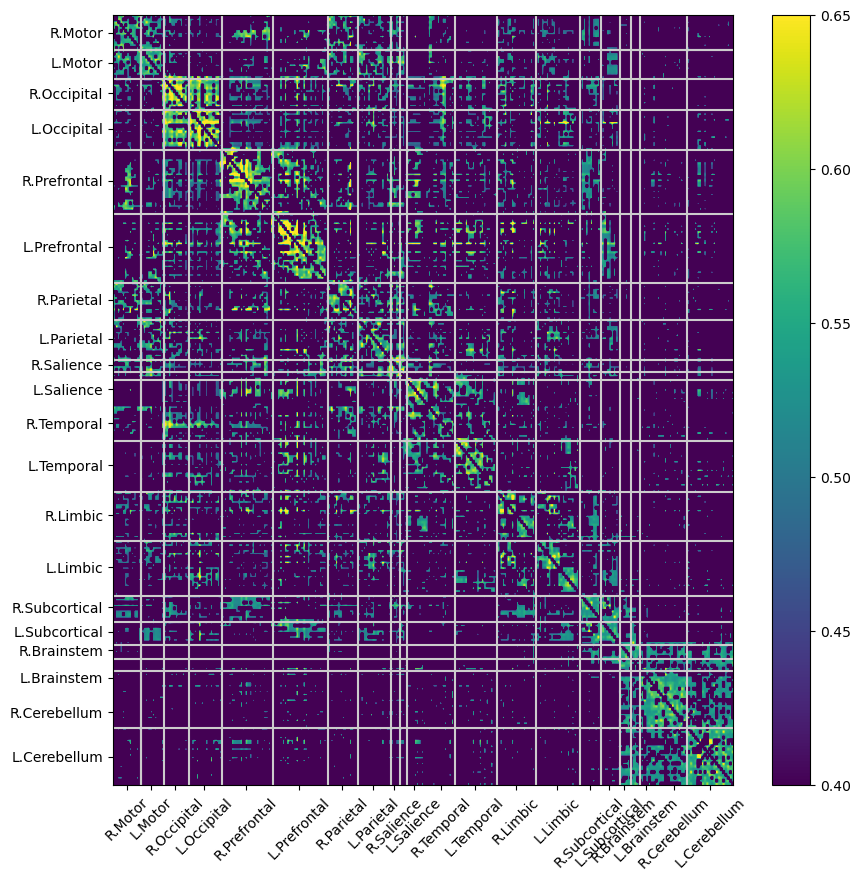

In [25]:
attmap = torch.zeros(268,268)
attmap[skeleton.indices()[0],skeleton.indices()[1]] = edge_atts.mean(dim=0)
attmap = attmap + attmap.T
plt_sort_anatomy(attmap, clim=[0.4, 0.65])

### Visualize node and edge attention in super-pixel images

In [26]:
s_idx = [21,25,36,44,52,50,51,60,72,75,79,81,98,102,123,138,139]
Subset(dataset,s_idx)

In [33]:
keig = 10
s_idx = [21,25,36,44,52,50,51,60,72,75,79,81,98,102,123,138,139]
dataset = GNNBenchmarkDataset(root='data/CIFAR10_bm',name='CIFAR10',split='test')
graphset = CIFAR10SP_EigPE_MLGC(root=osp.join('data/CIFAR10_bm','test'),dataset=dataset, keig=keig+1)
raw_loader = DataLoader(Subset(dataset,s_idx), batch_size=1, shuffle=False, num_workers=1)
graph_loader = DataLoader(Subset(graphset,s_idx), batch_size=1, shuffle=False, num_workers=1)
import torchvision as tv
cifar_test = Subset(tv.datasets.CIFAR10(root='/data/CIFAR10', train=False),s_idx)

Processing...
Done!


In [28]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = HL_HGAT_CIFAR10SP(channels=[2,2,2], filters=[64,128,256],mlp_channels=[256], 
                 K=6, dropout_ratio=0.0, dropout_ratio_mlp=0.0, keig=keig).to(device) 
save_name = 'HL_HGAT_CIFAR10'
save_path = './weights/' + save_name + '.pt'
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [29]:
attss, attts = [], []
model.eval()
for datas, raw_data in zip(graph_loader,raw_loader):
    with torch.no_grad():
        att_t, att_s=model(datas)
    attss.append(att_s.cpu())
    attts.append(att_t.cpu())

In [30]:
from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx

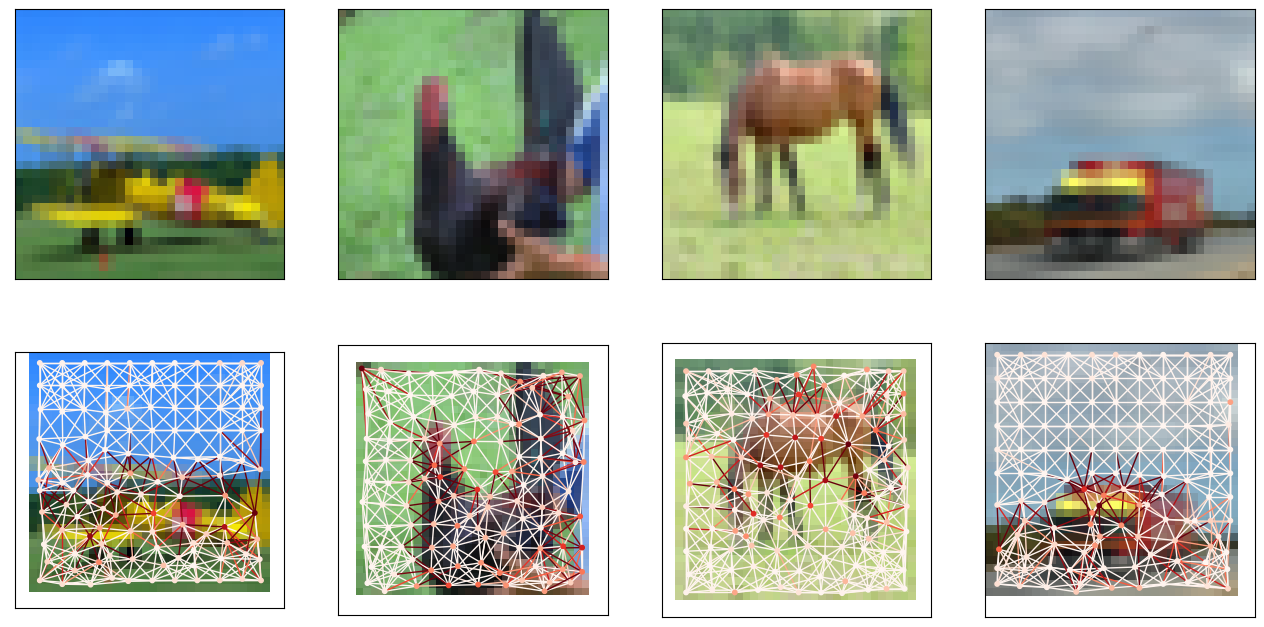

In [31]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
for i,pid in enumerate([3,1,7,16]):
    plt.subplot(2,4,i+1)
    img = cifar_test[pid][0]
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
for i,pid in enumerate([3,1,7,16]):
    plt.subplot(2,4,i+5)
    img = cifar_test[pid][0]
    plt.imshow(img)
    att_t = attts[pid].view(-1).detach().cpu()
    att_s = attss[pid].view(-1).detach().cpu()
    att_t = (att_t-att_t.min()) / (att_t.max()-att_t.min())
    att_s = (att_s-att_s.min()) / (att_s.max()-att_s.min())
    data = graphset[s_idx[pid]][0]
    rdata = dataset[s_idx[pid]]
    datax = Data(x=data.x_t, edge_index=data.edge_index, edge_attr=data.x_s[:,0])
    netdata = to_networkx(data.detach().cpu(),to_undirected=True)
    pos = {}
    for i in range(rdata.x.shape[0]):
         pos[i] = np.array([rdata.pos[i,1],rdata.pos[i,0]])*32
    node_size = 10
    temp = nx.draw_networkx(netdata, pos=pos, with_labels=False, node_size=node_size,
                     edge_color=1-att_s.numpy(), cmap=plt.cm.Reds,vmin=0.15,vmax=1.0, edge_cmap=plt.cm.Reds,
                           node_color=att_t.numpy(),width=1.0,edge_vmin=0.1,edge_vmax=1)